## Preprocess DataFrame and Handle Categorical Features for Clustering

Project Goal: Cluster users together to recommend songs.

This notebook focuses on preprocessing the `users_df` for clustering. The steps taken include:

*   **Handling Missing Values:** Rows with NaN values were dropped.
*   **Outlier Consideration and Scaling:** Instead of dropping users based on a play count cutoff, numerical features were scaled using `RobustScaler`, which is less sensitive to outliers than `MinMaxScaler` or `StandardScaler`. We did because we think there is value in knowing the preferred songs of power users.
*   **Categorical Feature Encoding:** We explored one-hot encoding for categorical features. Due to the high number of unique values in 'fav\_song' (over 119,000 unique values) and 'fav\_artist' (over 14,000 unique values), one-hot encoding both of these columns is not feasible due to memory constraints. We decided on only encoding 'fav\_artist'. We identified that 'fav\_maj\_genre' and 'fav\_min\_genre' have manageable unique values for one-hot encoding.

The preprocessed data, `users_df_encoded` (which includes our transformations), is now prepared for further analysis, such as dimensionality reduction with PCA and subsequent K-Means clustering. We save this processed df to our drive so that we can logically separate notebooks and not recompute.

### Load Data

In [1]:
!pip install pyarrow  # to save data to a parquet file

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [3]:
# if local
cleaned_users_path = "data/users_cleaned_df.parquet"

In [4]:
# # if collab
# from google.colab import drive
#
# drive.mount('/content/drive')
# cleaned_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df.parquet"

In [5]:
users_polars_df = pl.read_parquet(cleaned_users_path)

In [6]:
users_df_original = users_polars_df.to_pandas(use_pyarrow_extension_array=True)


In [7]:
users_df = users_df_original.copy()

### EDA and preprocessing
We thought we would drop outlier users but decided against it and went for a scaler that accounts for outliers. We include some of our EDA.

In [8]:
users_df[users_df['user_id'] == '093cb74eb3c517c5179ae24caf0ebec51b24d2a2']

,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_genre,fav_maj_count,fav_min_genre,fav_min_count,fav_year,year_count,fav_artist,fav_artist_plays,fav_song,fav_song_plays,fav_song_duration,tot_fav_song_play_time
33488,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,11697,2408769.69526,98,98,Rock,39,Rock,8,2009,17,AR4DW2Q1187FB44DB6,3,SOAOSDF12A58A779F1,9667,201.56036,1948484.00012


In [9]:
users_df = users_df.dropna()

In [10]:
users_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0
mean,75.07252,18605.09512,27.352648,27.352648,15.393956,3.465819,2001.04953,5.766003,5.351766,12.863076,250.97062,3232.460024
std,106.195572,26308.410928,35.009184,35.009184,21.17347,4.441338,10.043838,5.842962,5.855139,24.700324,88.089775,6284.948665
min,1.0,52.89751,1.0,1.0,1.0,1.0,1924.0,1.0,1.0,1.0,1.12281,1.12281
25%,17.0,4263.698,9.0,9.0,4.0,1.0,1999.0,2.0,2.0,3.0,202.57914,764.44552
50%,39.0,9661.94607,15.0,15.0,8.0,2.0,2005.0,4.0,3.0,7.0,237.7922,1658.5098
75%,90.0,22240.834945,32.0,32.0,18.0,4.0,2008.0,7.0,7.0,15.0,280.97261,3603.01176
max,11697.0,2408769.69526,2365.0,2365.0,1411.0,216.0,2010.0,267.0,80.0,9667.0,2328.11057,1948484.00012


<Axes: title={'center': 'fav_min_count'}, ylabel='Frequency'>

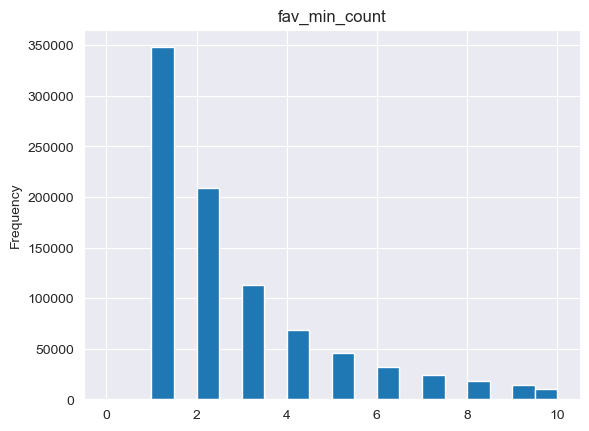

In [11]:
hist_var = 'fav_min_count'  #"unqiue_song_count"#'fav_song_duration'
users_df[hist_var].plot(
    kind='hist',
    bins=20,
    title=hist_var,
    range=(0, 10)  # min is 10
)

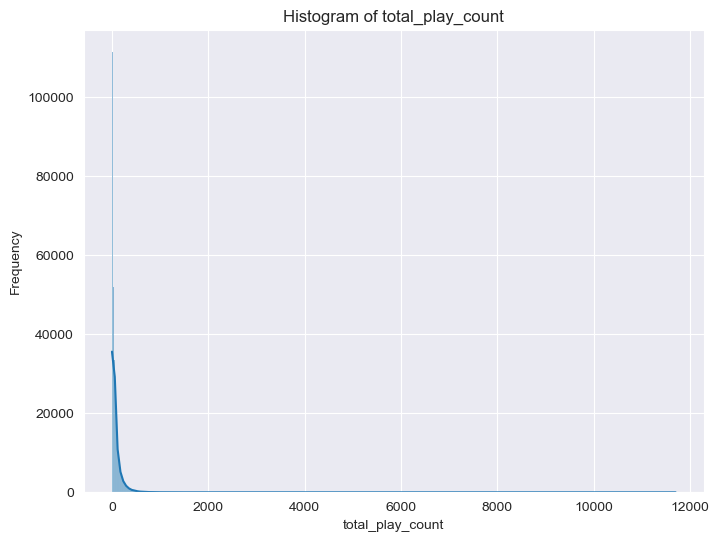

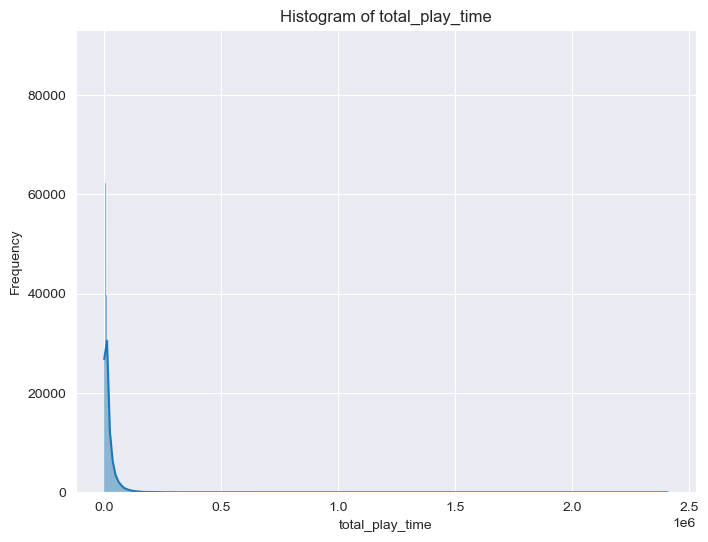

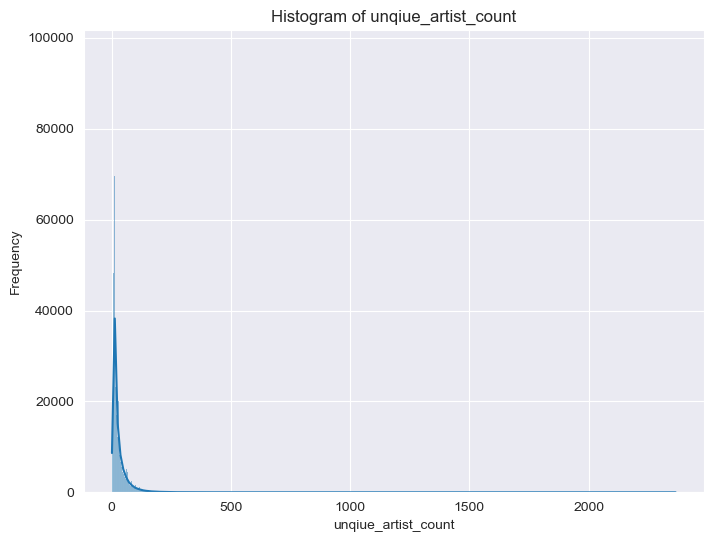

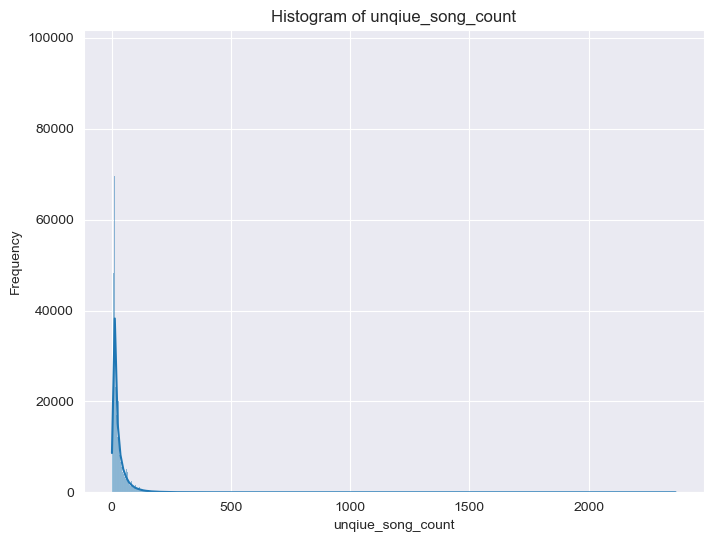

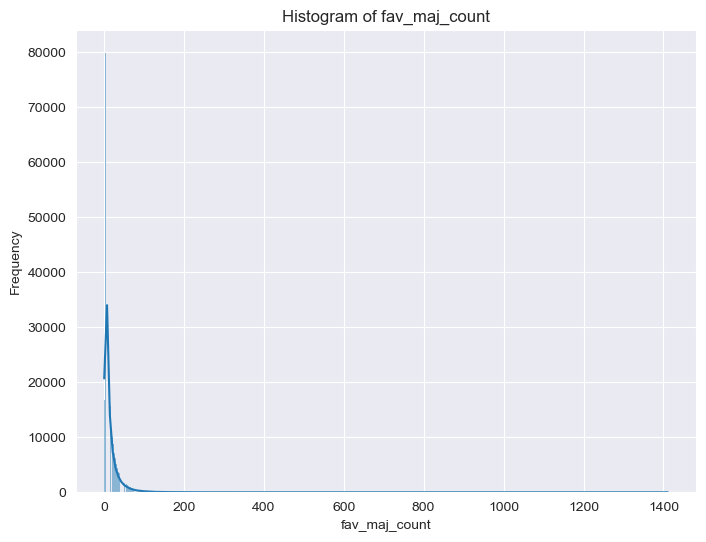

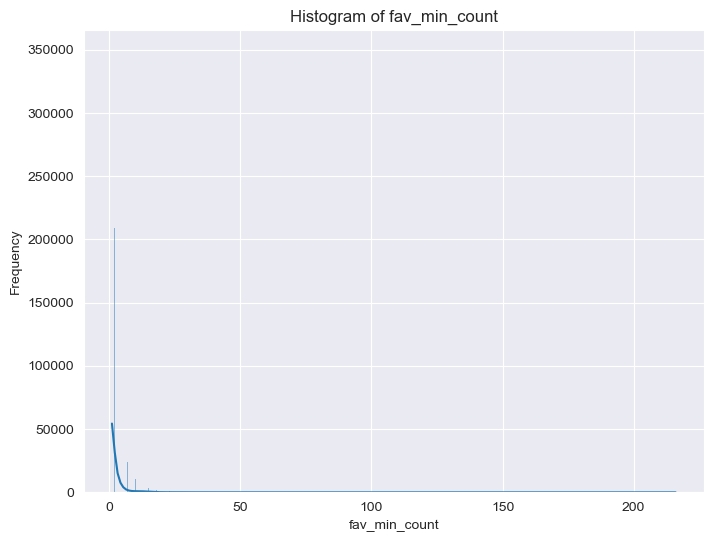

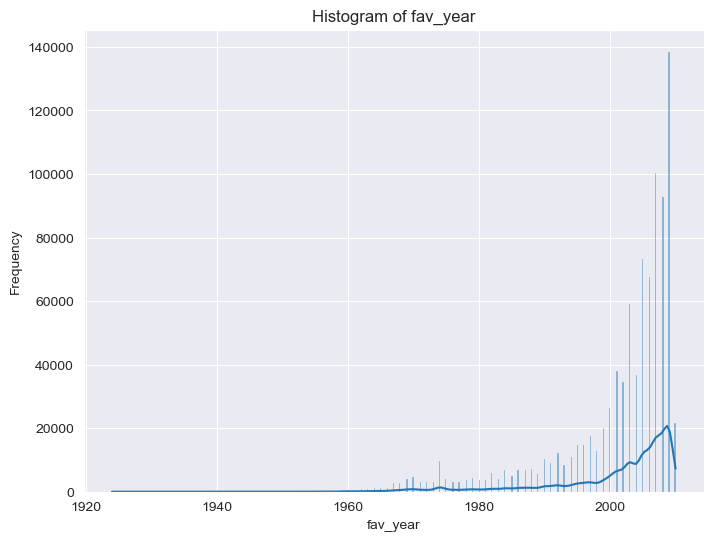

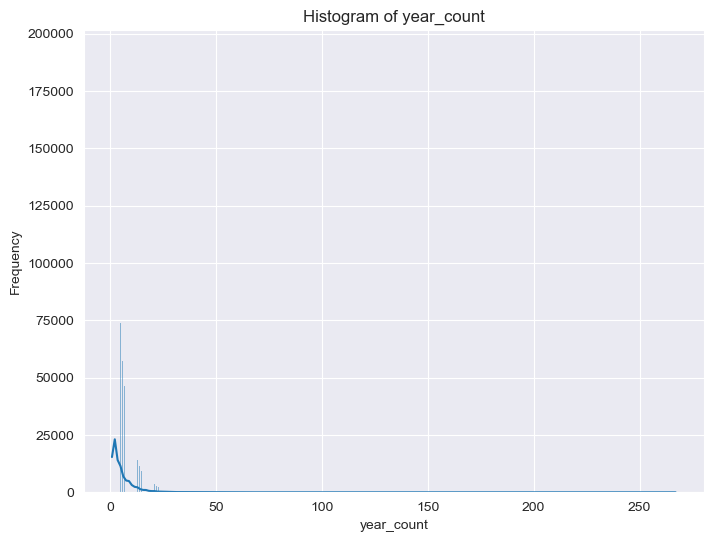

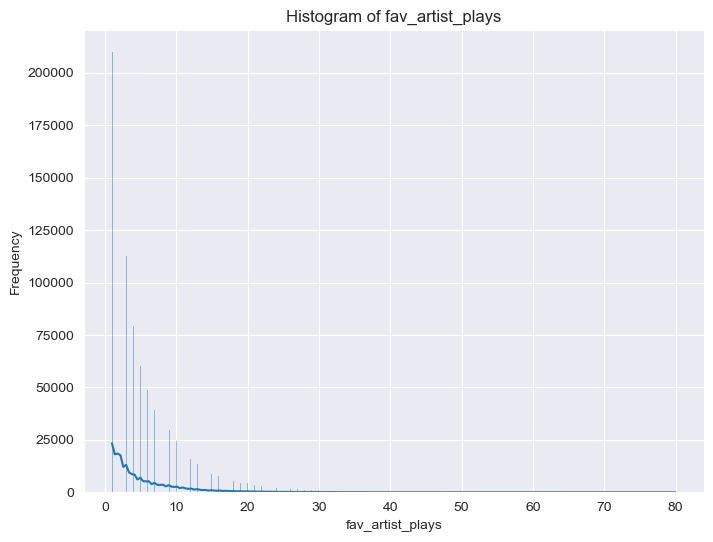

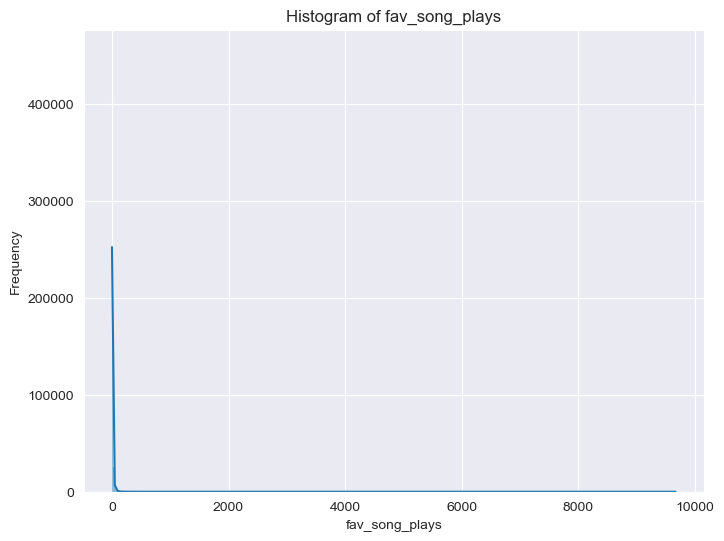

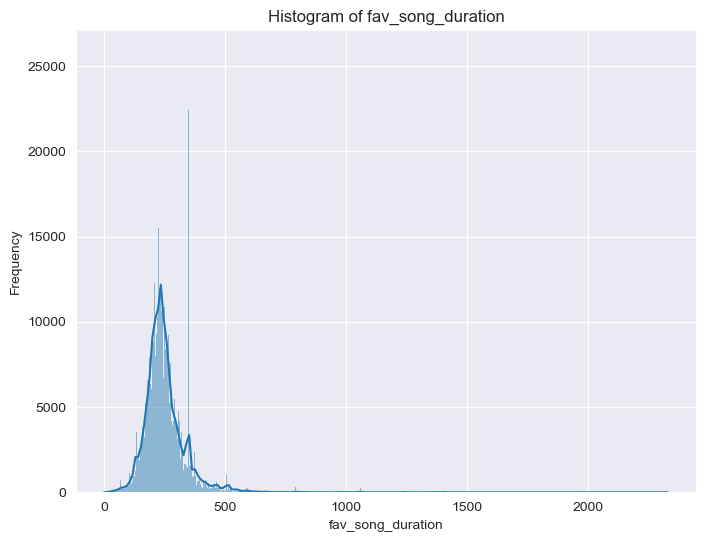

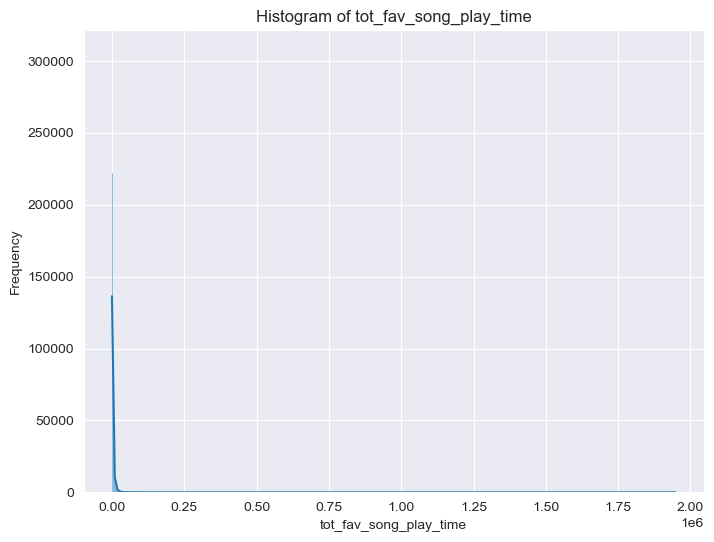

In [12]:
numerical_cols = users_df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(users_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#### Filter Data

In [13]:
#playlists are generated for users who listen to more than 10 different songs (i.e the size of our playlist)
# we can just recommend generic songs to users that don't or are new
filtered_users_df = users_df[users_df['unqiue_song_count'] > 10]
#we only sonsider user that like listening to tracks/songs that are more than 30 seconds and less than 10 minutes
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_duration'] > 30]
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_duration'] < 600]


# We don't include power users as they don't form clusters with others
filtered_users_df = filtered_users_df[filtered_users_df['total_play_time'] < 70000]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_count'] < 5000]

#We don't include users that listen to less than ten times
filtered_users_df = filtered_users_df[filtered_users_df['total_play_count'] > 10]

#We don't include users that listen to less than 1 hour of music
filtered_users_df = filtered_users_df[filtered_users_df['total_play_time'] > 3600]

#filtering users who listen to just one song for over 10 hours
filtered_users_df = filtered_users_df[filtered_users_df['tot_fav_song_play_time'] < 36000]

#not really a favorite if they only play it once
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_plays'] > 1]
filtered_users_df = filtered_users_df[filtered_users_df['fav_artist_plays'] > 1]
filtered_users_df = filtered_users_df[filtered_users_df['year_count'] > 1]
# filtered_users_df = filtered_users_df[filtered_users_df['year_count'] > 1]


# users_df = users_df[users_df['total_play_count'] < 200]
# users_df = users_df[users_df['total_play_count'] > 24]
# users_df = users_df[users_df['unqiue_song_count'] > 15]
# users_df = users_df[users_df['fav_year'] > 2000]
# users_df = users_df[users_df['total_play_time'] < 70000]
len(filtered_users_df)

503333

In [14]:
users_df = filtered_users_df

In [15]:
users_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0
mean,84.400417,20771.706216,34.972517,34.972517,19.719019,4.288614,2003.487165,7.37889,7.139152,12.856689,247.699283,3163.181044
std,62.430271,15296.856161,26.577554,26.577554,16.762437,4.150395,7.088148,5.036184,5.824787,13.649475,75.097588,3494.154956
min,12.0,3600.03283,11.0,11.0,2.0,1.0,1947.0,2.0,2.0,2.0,30.35383,63.4244
25%,36.0,8912.51744,17.0,17.0,9.0,2.0,2002.0,4.0,3.0,5.0,202.44853,1085.2549
50%,64.0,15869.51308,26.0,26.0,14.0,3.0,2006.0,6.0,5.0,9.0,237.11302,2022.10857
75%,115.0,28458.97975,44.0,44.0,24.0,5.0,2008.0,9.0,9.0,16.0,278.36036,3860.41905
max,662.0,69998.62687,279.0,279.0,252.0,97.0,2010.0,132.0,76.0,319.0,599.71873,35999.30592


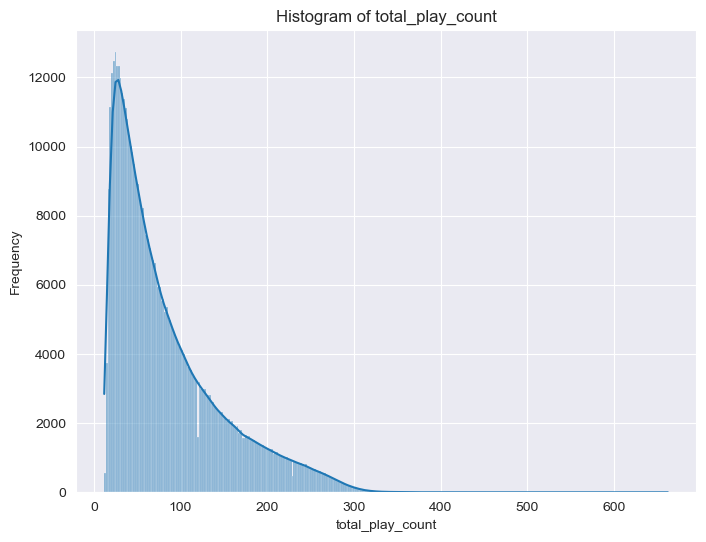

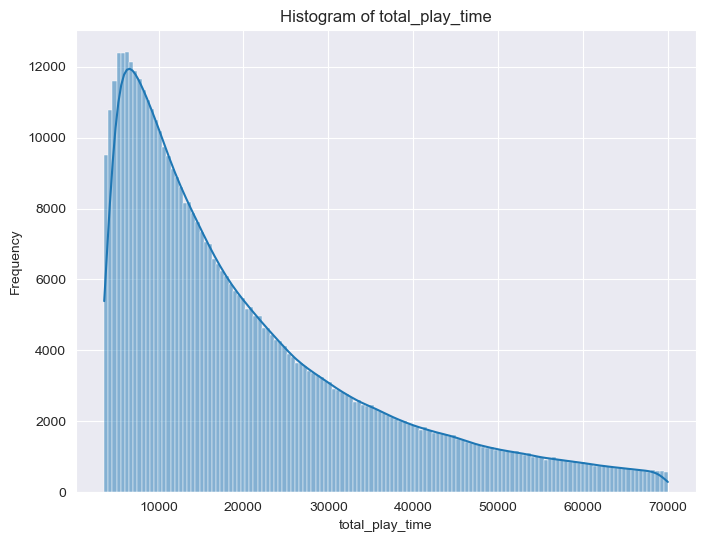

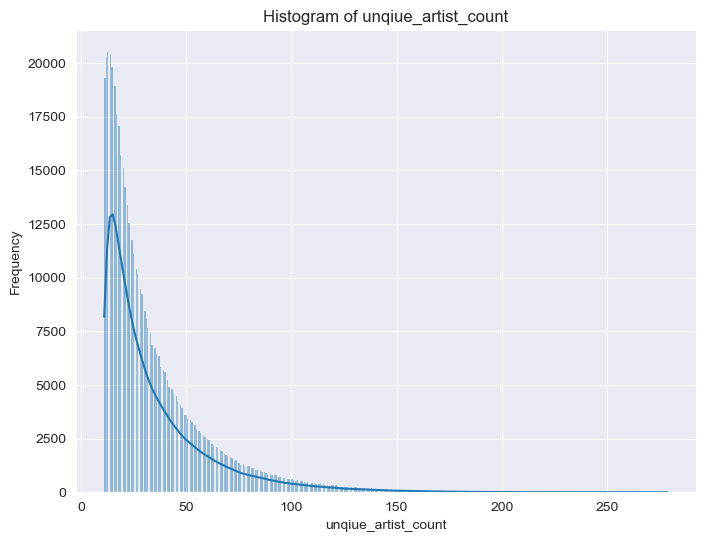

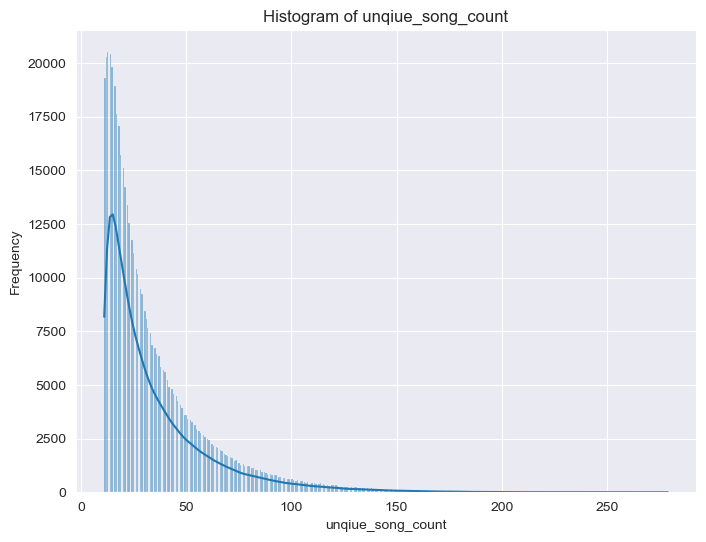

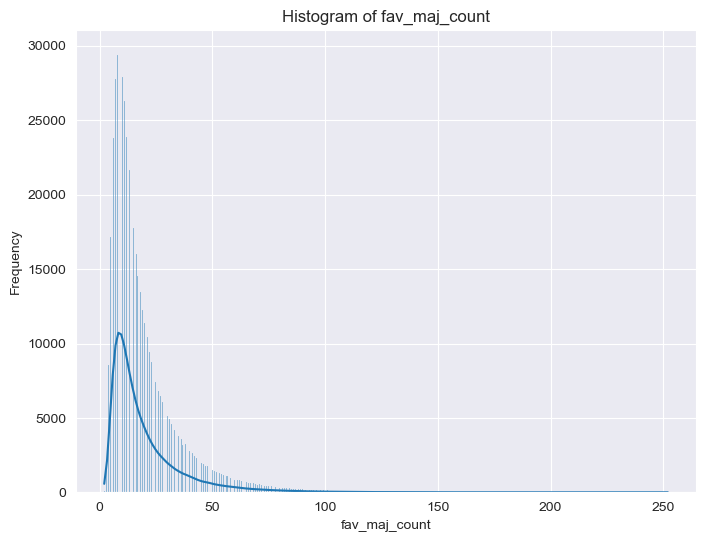

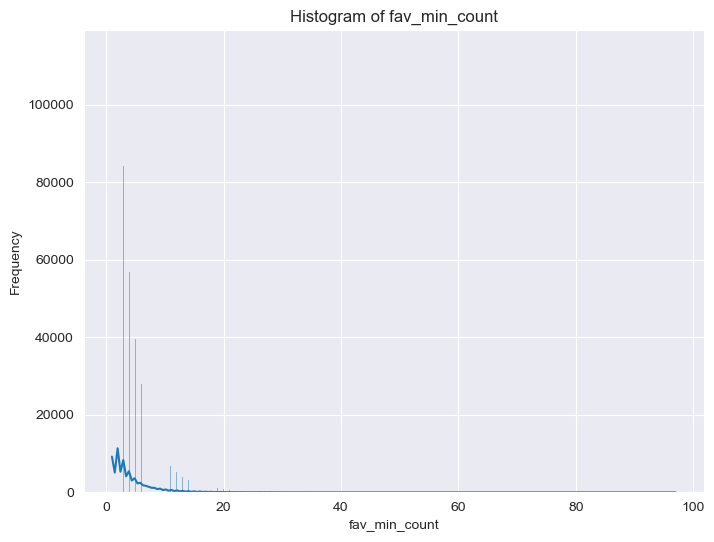

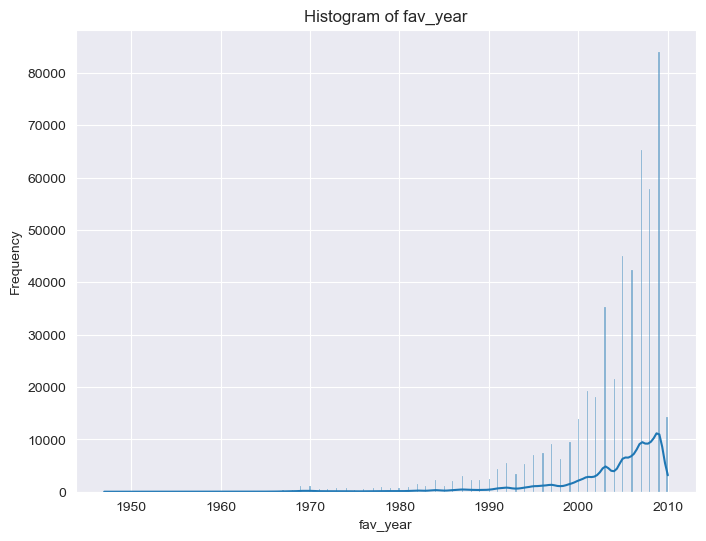

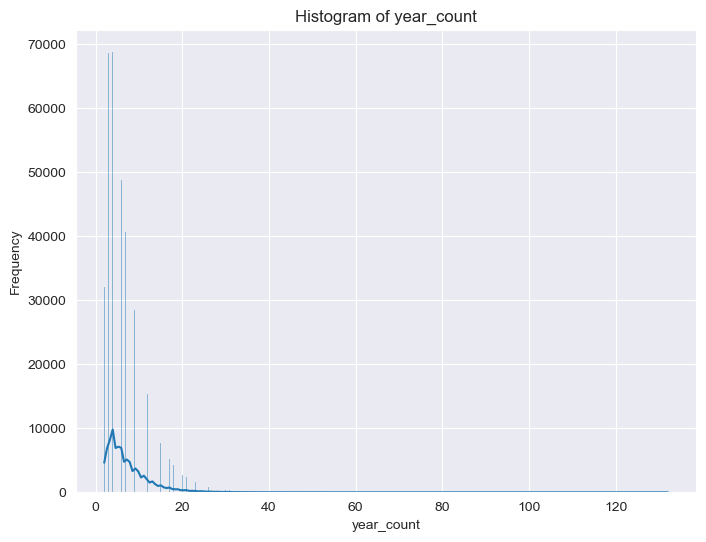

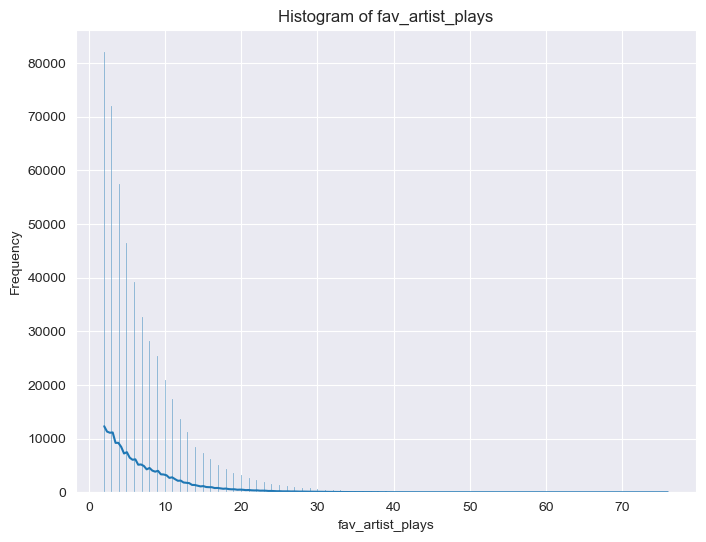

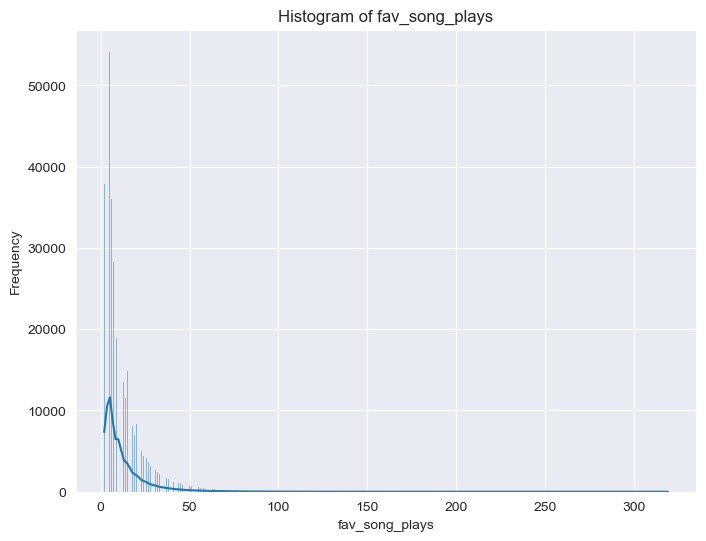

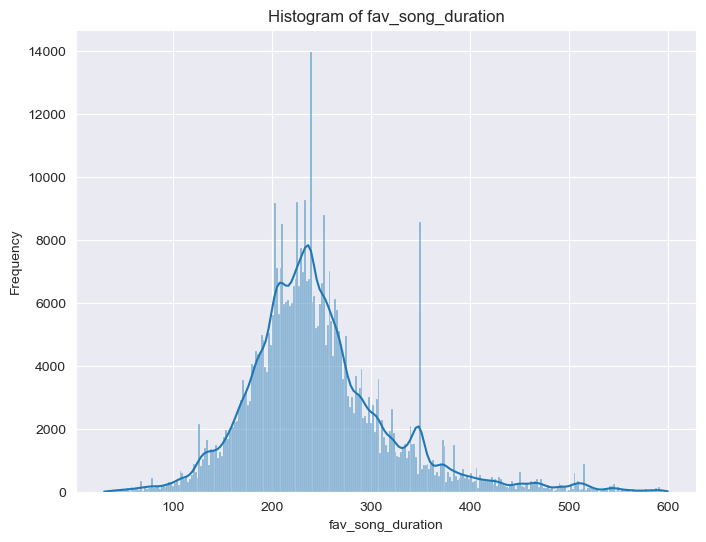

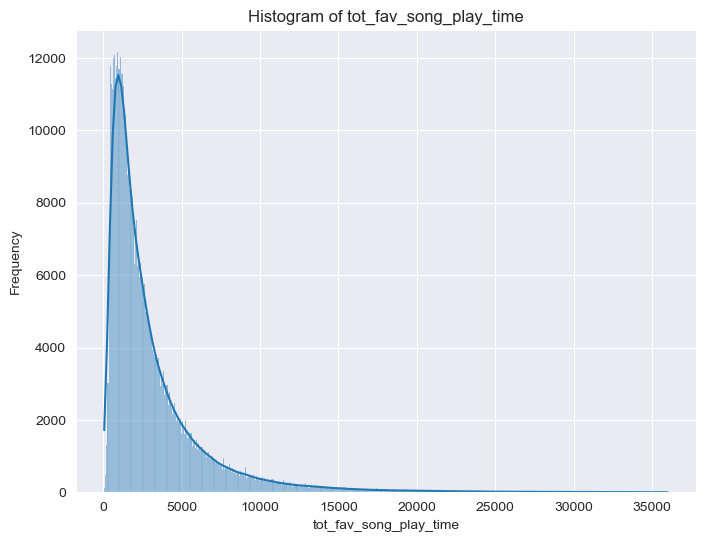

In [16]:
numerical_cols = filtered_users_df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(filtered_users_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#### Scaling Numerical Features

After deciding not to drop users based on play count, we focused on scaling numerical features. We found `MinMaxScaler` was heavily influenced by outliers, compressing most data into a small range with a low mean. Based on scikit-learn documentation, we selected `RobustScaler` as it uses robust statistics (median and interquartile range) and is less sensitive to outliers, making it more suitable for our dataset.

In [17]:
# Select numerical columns to normalize and standardize
numerical_cols = users_df.select_dtypes(include=['number']).columns

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# Apply minmax scaling
users_df_normalized = users_df.copy()
users_df_normalized[numerical_cols] = scaler_minmax.fit_transform(users_df_normalized[numerical_cols])

# Apply robust scaling
users_df_robustscaled = users_df.copy()
users_df_robustscaled[numerical_cols] = scaler_robust.fit_transform(users_df_robustscaled[numerical_cols])

print("Original Data:")
display(users_df[numerical_cols].describe())

print("MinMax Data:")
display(users_df_normalized[numerical_cols].describe())

print("Robust Scaled Data:")
display(users_df_robustscaled[numerical_cols].describe())

Original Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0
mean,84.400417,20771.706216,34.972517,34.972517,19.719019,4.288614,2003.487165,7.37889,7.139152,12.856689,247.699283,3163.181044
std,62.430271,15296.856161,26.577554,26.577554,16.762437,4.150395,7.088148,5.036184,5.824787,13.649475,75.097588,3494.154956
min,12.0,3600.03283,11.0,11.0,2.0,1.0,1947.0,2.0,2.0,2.0,30.35383,63.4244
25%,36.0,8912.51744,17.0,17.0,9.0,2.0,2002.0,4.0,3.0,5.0,202.44853,1085.2549
50%,64.0,15869.51308,26.0,26.0,14.0,3.0,2006.0,6.0,5.0,9.0,237.11302,2022.10857
75%,115.0,28458.97975,44.0,44.0,24.0,5.0,2008.0,9.0,9.0,16.0,278.36036,3860.41905
max,662.0,69998.62687,279.0,279.0,252.0,97.0,2010.0,132.0,76.0,319.0,599.71873,35999.30592


MinMax Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000
mean,0.111385,0.258615,0.089450,0.089450,0.070876,0.034256,0.896622,0.041376,0.069448,0.034248,0.381733,0.086258
std,0.096047,0.230379,0.099170,0.099170,0.067050,0.043233,0.112510,0.038740,0.078713,0.043058,0.131897,0.097233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.036923,0.080009,0.022388,0.022388,0.028000,0.010417,0.873016,0.015385,0.013514,0.009464,0.302257,0.028435
50%,0.080000,0.184785,0.055970,0.055970,0.048000,0.020833,0.936508,0.030769,0.040541,0.022082,0.363140,0.054505
75%,0.158462,0.374390,0.123134,0.123134,0.088000,0.041667,0.968254,0.053846,0.094595,0.044164,0.435585,0.105660
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Robust Scaled Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000,503333.000000
mean,0.258233,0.250797,0.332315,0.332315,0.381268,0.429538,-0.418806,0.275778,0.356525,0.350608,0.139455,0.411173
std,0.790257,0.782589,0.984354,0.984354,1.117496,1.383465,1.181358,1.007237,0.970798,1.240861,0.989274,1.259080
min,-0.658228,-0.627708,-0.555556,-0.555556,-0.800000,-0.666667,-9.833333,-0.800000,-0.500000,-0.636364,-2.723675,-0.705790
25%,-0.354430,-0.355921,-0.333333,-0.333333,-0.333333,-0.333333,-0.666667,-0.400000,-0.333333,-0.363636,-0.456641,-0.337585
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.645570,0.644079,0.666667,0.666667,0.666667,0.666667,0.333333,0.600000,0.666667,0.636364,0.543359,0.662415
max,7.569620,2.769254,9.370370,9.370370,15.866667,31.333333,0.666667,25.200000,11.833333,28.181818,4.776669,12.243311


One hot encode categorical data

The number of unique favorite arists: 14,975. This is manageable.

The number of unique favorite songs is 119,417. This takes too much RAM.

In [18]:
# Count unique categorical values
num_unique_artists = users_df['fav_artist'].nunique()
num_unique_songs = users_df['fav_song'].nunique()  # too many
num_unique_maj_genres = users_df['fav_maj_genre'].nunique()
num_unique_min_genres = users_df['fav_min_genre'].nunique()

print(f"Number of unique favorite artists: {num_unique_artists}")
print(f"Number of unique favorite songs: {num_unique_songs}")
print(f"Number of unique favorite major genres: {num_unique_maj_genres}")
print(f"Number of unique favorite minority genres: {num_unique_min_genres}")

Number of unique favorite artists: 7475
Number of unique favorite songs: 58247
Number of unique favorite major genres: 15
Number of unique favorite minority genres: 15


In [19]:
# Select categorical columns for one-hot encoding
# ['fav_song'] a ton of these guys = run out of ram if try to use so omit
users_df_robustscaled = users_df_robustscaled.drop(columns=["fav_song"])
# Features to do one-hot encoding on
categorical_cols = ['fav_maj_genre', 'fav_min_genre', 'fav_artist']
users_df_encoded = pd.get_dummies(users_df_robustscaled, columns=categorical_cols, dummy_na=False)

print("Original DataFrame shape:", users_df_robustscaled.shape)
print("DataFrame shape after one-hot encoding:", users_df_encoded.shape)
display(users_df_encoded.head())

Original DataFrame shape: (503333, 16)
DataFrame shape after one-hot encoding: (503333, 7518)


,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,...,fav_artist_ARZXNFV1187B9BA2CD,fav_artist_ARZXTEY1187B9997A7,fav_artist_ARZXZ731187B9B8813,fav_artist_ARZYJO61187B98F4B9,fav_artist_ARZYPLF1187FB45B9B,fav_artist_ARZYSCW1187FB52DF7,fav_artist_ARZYT8C1187FB4D57F,fav_artist_ARZYZUU11F4C841DCC,fav_artist_ARZZLLI1187B99C8DD,fav_artist_ARZZMWO1187B9AFB36
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,-0.582278,-0.586948,-0.555556,-0.555556,-0.266667,0.000000,0.500000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,-0.569620,-0.548481,-0.296296,-0.296296,-0.066667,0.666667,0.000000,-0.4,-0.5,...,False,False,False,False,False,False,False,False,False,False
6,00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,-0.113924,-0.184480,0.296296,0.296296,1.266667,-0.666667,0.333333,0.8,3.0,...,False,False,False,False,False,False,False,False,False,False
9,00007ed2509128dcdd74ea3aac2363e24e9dc06b,-0.329114,-0.311102,0.222222,0.222222,0.800000,0.333333,-0.333333,0.4,2.0,...,False,False,False,False,False,False,False,False,False,False
14,0000bb531aaa657c932988bc2f7fd7fc1b2050ec,0.367089,0.553635,1.259259,1.259259,1.266667,1.000000,-1.833333,1.0,0.5,...,False,False,False,False,False,False,False,False,False,False


### Save processed dataframe

In [20]:
# if local
users_cleaned_and_encoded_path = "data/users_cleaned_encoded_500k_df.parquet"

In [21]:
# # if collab
# users_cleaned_and_encoded_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"

In [22]:
# Save the processed dataframe to Parquet
users_df_encoded.to_parquet(users_cleaned_and_encoded_path, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_cleaned_and_encoded_path}")

Processed DataFrame saved to: data/users_cleaned_encoded_500k_df.parquet
